In [1]:
import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import folium
import math
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from sodapy import Socrata
from rasterio.plot import show
from folium import Map, TileLayer, LayerControl, plugins
from folium.raster_layers import ImageOverlay
from folium.plugins import MarkerCluster
from pyproj import Transformer
from shapely.geometry import shape, MultiPolygon, Point
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
from scipy.interpolate import RBFInterpolator
from pyproj import Transformer

In [2]:
# Carga el GeoJSON como un GeoDataFrame
gdf_sigpac = gpd.read_file('geometrias_sigpac.geojson')

In [3]:
gdf_sigpac_epsg_4326 = gdf_sigpac.to_crs(epsg=4326)

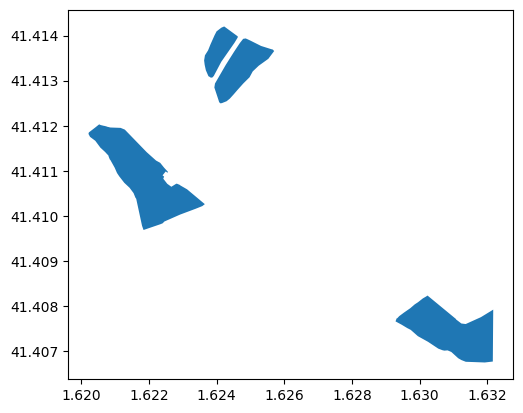

In [4]:
gdf_sigpac_epsg_4326.plot()
plt.show()

In [5]:
# Función para convertir geometría
def safe_shape(geom):
    try:
        return shape(geom) if isinstance(geom, dict) else None
    except Exception as e:
        print(f"Error al convertir la geometría: {e}")
        return None
    


In [6]:
def fetch_icgc_socrata_api_data(api_url, query=None, registers_limit=40000, geom_field=None, crs_epsg_output=None):
    #params examples:
    #api_url="si4p-ygat"; #Dades de parcel·les d’explotacions (DUN) de Catalunya
    #api_url="iqpi-zasj"; #Mapa d’explotacions agrícoles (DUN) de Catalunya
    #api_url="yh94-j2n9"; #Mapa de cultius de Catalunya amb origen DUN
    #query = f"nom_mun='LINYOLA'"
    #min_lat, max_lat = 41.67, 41.75; min_lon, max_lon = 0.85, 0.93
    #query = f"within_box(the_geom, {min_lat}, {min_lon}, {max_lat}, {max_lon})"
    #registers_limit = 10000
    #crs_epsg_output=25831
    
    # Conectar a la API
    client = Socrata("analisi.transparenciacatalunya.cat", None)
    
    # First 2000 results, returned as JSON from API / converted to Python list of
    # dictionaries by sodapy.

    results = client.get(api_url, where=query, limit=registers_limit)

    # Convert to pandas DataFrame
    results_df = pd.DataFrame.from_records(results)
    
    if geom_field is not None:

        # Convertir la columna de geometría en objetos de geometría Shapely, manejando errores
        results_df['geometry'] = results_df[geom_field].apply(safe_shape)

        # Filtrar filas con geometrías válidas
        #results_df = results_df[results_df['geometry'].notnull()]

        # Create a GeoDataFrame
        results_gdf = gpd.GeoDataFrame(results_df, geometry='geometry', crs=4326)

        # Reproject to desired crs
        results_gdf = results_gdf.to_crs(epsg=crs_epsg_output)  

        # Visualizar los datos
        results_gdf.plot()
        plt.show()
        
        return results_gdf
    
    else:
        
        return results_df

In [7]:
#Definició Bounding Box Query Consulta APIs: #https://dev.socrata.com/foundry/analisi.transparenciacatalunya.cat/
min_lat, max_lat = 41.3, 41.5
min_lon, max_lon = 1.45, 1.75
query = f"within_box(geocoded_column, {min_lat}, {min_lon}, {max_lat}, {max_lon})"
registers_limit = 1000000
geom_field='the_geom'
crs_epsg_output=4326

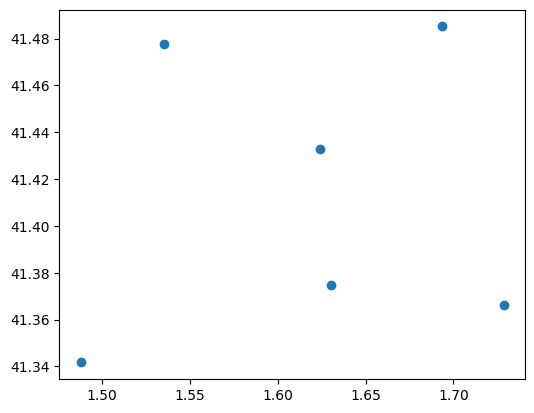

In [8]:
#Request Metadades Estacions Meteorologíques XEMA
gdf_estacions_meteo=fetch_icgc_socrata_api_data("yqwd-vj5e", query, registers_limit, "geocoded_column", crs_epsg_output)

In [9]:
gdf_estacions_meteo

,codi_estacio,nom_estacio,codi_tipus,latitud,longitud,geocoded_column,emplacament,altitud,codi_municipi,nom_municipi,codi_comarca,nom_comarca,codi_provincia,nom_provincia,codi_xarxa,nom_xarxa,codi_estat_ema,nom_estat_ema,data_inici,geometry
0,UH,el Montmell,A,41.34171,1.48769,"{'type': 'Point', 'coordinates': [1.48769, 41....",Finca Vallflor - Aigua Viva,545,430901,El Montmell,12,Baix Penedes,43,Tarragona,1,XEMA,2,Operativa,1995-07-13T00:00:00.000,POINT (1.48769 41.34171)
1,XB,la Llacuna,A,41.4779,1.53529,"{'type': 'Point', 'coordinates': [1.53529, 41....",Cal Mateu,584,81043,La Llacuna,6,Anoia,8,Barcelona,1,XEMA,2,Operativa,2008-03-19T00:00:00.000,POINT (1.53529 41.4779)
2,U3,Sant Marti Sarroca,A,41.37491,1.63032,"{'type': 'Point', 'coordinates': [1.63032, 41....",Mas Rabell de Fontenac,257,82270,Sant Marti Sarroca,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,1997-05-24T00:00:00.000,POINT (1.63032 41.37491)
3,WP,Canaletes,A,41.48518,1.69337,"{'type': 'Point', 'coordinates': [1.69337, 41....",Camp del Roure - Can Feixes,325,81228,Mediona,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,2002-05-17T00:00:00.000,POINT (1.69337 41.48518)
4,W4,Vilafranca del Penedes - la Granada,A,41.36619,1.72857,"{'type': 'Point', 'coordinates': [1.72857, 41....",Rasa de Sagols,240,83054,Vilafranca del Penedes,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,1999-12-25T00:00:00.000,POINT (1.72857 41.36619)
5,DI,Font-rubi,A,41.43292,1.62386,"{'type': 'Point', 'coordinates': [1.62386, 41....",Masia Ca l'Amalia - Montjuic,415,80850,Font-rubi,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,1998-07-16T00:00:00.000,POINT (1.62386 41.43292)


In [10]:
gdf_estacions_meteo2=gdf_estacions_meteo

In [11]:
gdf_estacions_meteo2=gdf_estacions_meteo2.rename(columns={"codi_estacio": "id_WeatherStation", "nom_estacio": "name_WeatherStation", "latitud":"latitude", "longitud":"longitude", "emplacament":"location", "altitud":"altitude", "data_inici": "start_date", "codi_municipi":"code_municipality", "nom_municipi":"name_municipality"})

In [12]:
gdf_estacions_meteo_english=gdf_estacions_meteo2.iloc[:,[0, 1, 3, 4, 5, 6, 18, 7, 8, 9, 10, 11, 12, 13]]

In [13]:
gdf_estacions_meteo_english

,id_WeatherStation,name_WeatherStation,latitude,longitude,geocoded_column,location,start_date,altitude,code_municipality,name_municipality,codi_comarca,nom_comarca,codi_provincia,nom_provincia
0,UH,el Montmell,41.34171,1.48769,"{'type': 'Point', 'coordinates': [1.48769, 41....",Finca Vallflor - Aigua Viva,1995-07-13T00:00:00.000,545,430901,El Montmell,12,Baix Penedes,43,Tarragona
1,XB,la Llacuna,41.4779,1.53529,"{'type': 'Point', 'coordinates': [1.53529, 41....",Cal Mateu,2008-03-19T00:00:00.000,584,81043,La Llacuna,6,Anoia,8,Barcelona
2,U3,Sant Marti Sarroca,41.37491,1.63032,"{'type': 'Point', 'coordinates': [1.63032, 41....",Mas Rabell de Fontenac,1997-05-24T00:00:00.000,257,82270,Sant Marti Sarroca,3,Alt Penedes,8,Barcelona
3,WP,Canaletes,41.48518,1.69337,"{'type': 'Point', 'coordinates': [1.69337, 41....",Camp del Roure - Can Feixes,2002-05-17T00:00:00.000,325,81228,Mediona,3,Alt Penedes,8,Barcelona
4,W4,Vilafranca del Penedes - la Granada,41.36619,1.72857,"{'type': 'Point', 'coordinates': [1.72857, 41....",Rasa de Sagols,1999-12-25T00:00:00.000,240,83054,Vilafranca del Penedes,3,Alt Penedes,8,Barcelona
5,DI,Font-rubi,41.43292,1.62386,"{'type': 'Point', 'coordinates': [1.62386, 41....",Masia Ca l'Amalia - Montjuic,1998-07-16T00:00:00.000,415,80850,Font-rubi,3,Alt Penedes,8,Barcelona


In [14]:
#Request Metadades Variables Meteorologíques XEMA
df_variables_meteo=fetch_icgc_socrata_api_data("4fb2-n3yi")

In [15]:
df_variables_meteo

,codi_variable,nom_variable,unitat,acronim,codi_tipus_var,decimals
0,44,Humitat relativa mínima,%,HRn,DAT,0
1,40,Temperatura màxima,°C,Tx,DAT,1
2,46,Velocitat del vent a 2 m (esc.),m/s,VV2,DAT,1
3,32,Temperatura,°C,T,DAT,1
4,72,Precipitació màxima en 1 minut,mm,PPTx1min,DAT,1
5,51,Direcció de la ratxa màxima del vent a 10 m,°,DVVx10,DAT,0
6,3,Humitat relativa màxima,%,HRx,DAT,0
7,30,Velocitat del vent a 10 m (esc.),m/s,VV10,DAT,1
8,56,Ratxa màxima del vent a 2 m,m/s,VVx2,DAT,1
9,31,Direcció de vent 10 m (m. 1),°,DV10,DAT,0


In [16]:
df_variables_meteo2=df_variables_meteo.iloc[:4]

In [17]:
df_variables_meteo2

,codi_variable,nom_variable,unitat,acronim,codi_tipus_var,decimals
0,44,Humitat relativa mínima,%,HRn,DAT,0
1,40,Temperatura màxima,°C,Tx,DAT,1
2,46,Velocitat del vent a 2 m (esc.),m/s,VV2,DAT,1
3,32,Temperatura,°C,T,DAT,1


In [18]:
df_variables_meteo_english=pd.DataFrame()
df_variables_meteo_english["id_QuantityKind_ObservedProperty"]=df_variables_meteo2["codi_variable"]
df_variables_meteo_english["name_QuantityKind_ObservedProperty"]=["Minimum relative humidity", "Maximum temperature", "Wind speed measured at 2 m height", "Temperature"]
df_variables_meteo_english["unit"]=df_variables_meteo2["unitat"]
df_variables_meteo_english["acronym"]=df_variables_meteo2["acronim"]
df_variables_meteo_english["decimals_of_resolution"]=df_variables_meteo2["decimals"]

In [19]:
df_variables_meteo_english

,id_QuantityKind_ObservedProperty,name_QuantityKind_ObservedProperty,unit,acronym,decimals_of_resolution
0,44,Minimum relative humidity,%,HRn,0
1,40,Maximum temperature,°C,Tx,1
2,46,Wind speed measured at 2 m height,m/s,VV2,1
3,32,Temperature,°C,T,1


In [20]:
#Request Dades Meteorologíques XEMA Filtrant Estacions d'Interés

# Filtres de Consulta
v_codi_estacio = gdf_estacions_meteo["codi_estacio"]
estacio_filter = ",".join([f"'{estacio}'" for estacio in v_codi_estacio])  # Formatea el filtro

# Crear una consulta amb rang de dates per l'any 2024
start_date = "2024-01-01T00:00:00.000"
end_date = "2024-12-31T23:59:59.999"

query3 = f"data_lectura >= '{start_date}' AND data_lectura <= '{end_date}' AND codi_estacio IN ({estacio_filter})"

#query3 = f"SELECT * WHERE year(data_lectura) = 2018 AND codi_estacio IN ({estacio_filter})"
df_dades_meteo=fetch_icgc_socrata_api_data("nzvn-apee", query3, 10000000)

In [21]:
df_dades_meteo

,id,codi_estacio,codi_variable,data_lectura,valor_lectura,codi_base,data_extrem,codi_estat
0,W4510101240000,W4,51,2024-01-01T00:00:00.000,27,SH,NaN,NaN
1,DI010101240000,DI,1,2024-01-01T00:00:00.000,969,SH,2024-01-01T00:14:00.000,NaN
2,DI020101240000,DI,2,2024-01-01T00:00:00.000,968.5,SH,2024-01-01T00:00:00.000,NaN
3,DI030101240000,DI,3,2024-01-01T00:00:00.000,69,SH,2024-01-01T00:29:00.000,NaN
4,DI300101240000,DI,30,2024-01-01T00:00:00.000,1.9,SH,NaN,NaN
...,...,...,...,...,...,...,...,...
1345476,XB353112242330,XB,35,2024-12-31T23:30:00.000,0,SH,NaN,T
1345477,XB403112242330,XB,40,2024-12-31T23:30:00.000,4.3,SH,2024-12-31T23:40:00.000,T
1345478,XB423112242330,XB,42,2024-12-31T23:30:00.000,4.1,SH,2024-12-31T23:59:00.000,T
1345479,XB443112242330,XB,44,2024-12-31T23:30:00.000,100,SH,2024-12-31T23:59:00.000,T


In [22]:
df_dades_meteo_english=pd.DataFrame()
df_dades_meteo_english["id_Observation"]=df_dades_meteo["id"]
df_dades_meteo_english["id_WeatherStation"]=df_dades_meteo["codi_estacio"]
df_dades_meteo_english["id_QuantityKind_ObservedProperty"]=df_dades_meteo["codi_variable"]
df_dades_meteo_english["dateTimeStamp"]=df_dades_meteo["data_lectura"]
df_dades_meteo_english["Result"]=df_dades_meteo["valor_lectura"]

In [23]:
df_dades_meteo_english

,id_Observation,id_WeatherStation,id_QuantityKind_ObservedProperty,dateTimeStamp,Result
0,W4510101240000,W4,51,2024-01-01T00:00:00.000,27
1,DI010101240000,DI,1,2024-01-01T00:00:00.000,969
2,DI020101240000,DI,2,2024-01-01T00:00:00.000,968.5
3,DI030101240000,DI,3,2024-01-01T00:00:00.000,69
4,DI300101240000,DI,30,2024-01-01T00:00:00.000,1.9
...,...,...,...,...,...
1345476,XB353112242330,XB,35,2024-12-31T23:30:00.000,0
1345477,XB403112242330,XB,40,2024-12-31T23:30:00.000,4.3
1345478,XB423112242330,XB,42,2024-12-31T23:30:00.000,4.1
1345479,XB443112242330,XB,44,2024-12-31T23:30:00.000,100


In [24]:
df_dades_meteo_english[(df_dades_meteo_english["id_WeatherStation"]=="DI") & (df_dades_meteo_english["id_QuantityKind_ObservedProperty"]=="32")]

,id_Observation,id_WeatherStation,id_QuantityKind_ObservedProperty,dateTimeStamp,Result
6,DI320101240000,DI,32,2024-01-01T00:00:00.000,6
83,DI320101240030,DI,32,2024-01-01T00:30:00.000,5.7
159,DI320101240100,DI,32,2024-01-01T01:00:00.000,5.5
237,DI320101240130,DI,32,2024-01-01T01:30:00.000,5.5
313,DI320101240200,DI,32,2024-01-01T02:00:00.000,5.6
...,...,...,...,...,...
1345101,DI323112242130,DI,32,2024-12-31T21:30:00.000,8.1
1345180,DI323112242200,DI,32,2024-12-31T22:00:00.000,8
1345255,DI323112242230,DI,32,2024-12-31T22:30:00.000,8
1345332,DI323112242300,DI,32,2024-12-31T23:00:00.000,8


In [25]:
df_dades_meteo_temp=df_dades_meteo[df_dades_meteo['codi_variable']=="32"]

In [26]:
df_dades_meteo_temp

,id,codi_estacio,codi_variable,data_lectura,valor_lectura,codi_base,data_extrem,codi_estat
6,DI320101240000,DI,32,2024-01-01T00:00:00.000,6,SH,NaN,NaN
18,U3320101240000,U3,32,2024-01-01T00:00:00.000,3.4,SH,NaN,NaN
32,UH320101240000,UH,32,2024-01-01T00:00:00.000,8,SH,NaN,NaN
47,W4320101240000,W4,32,2024-01-01T00:00:00.000,6.3,SH,NaN,NaN
57,WP320101240000,WP,32,2024-01-01T00:00:00.000,5.8,SH,NaN,NaN
...,...,...,...,...,...,...,...,...
1345423,U3323112242330,U3,32,2024-12-31T23:30:00.000,7.7,SH,NaN,T
1345436,UH323112242330,UH,32,2024-12-31T23:30:00.000,4.7,SH,NaN,T
1345451,W4323112242330,W4,32,2024-12-31T23:30:00.000,5.7,SH,NaN,T
1345461,WP323112242330,WP,32,2024-12-31T23:30:00.000,6.6,SH,NaN,T


In [ ]:
df_dades_meteo_temp["date"]=df_dades_meteo_temp["data_lectura"].str[0:10]

In [28]:
df_dades_meteo_temp

,id,codi_estacio,codi_variable,data_lectura,valor_lectura,codi_base,data_extrem,codi_estat,date
6,DI320101240000,DI,32,2024-01-01T00:00:00.000,6,SH,NaN,NaN,2024-01-01
18,U3320101240000,U3,32,2024-01-01T00:00:00.000,3.4,SH,NaN,NaN,2024-01-01
32,UH320101240000,UH,32,2024-01-01T00:00:00.000,8,SH,NaN,NaN,2024-01-01
47,W4320101240000,W4,32,2024-01-01T00:00:00.000,6.3,SH,NaN,NaN,2024-01-01
57,WP320101240000,WP,32,2024-01-01T00:00:00.000,5.8,SH,NaN,NaN,2024-01-01
...,...,...,...,...,...,...,...,...,...
1345423,U3323112242330,U3,32,2024-12-31T23:30:00.000,7.7,SH,NaN,T,2024-12-31
1345436,UH323112242330,UH,32,2024-12-31T23:30:00.000,4.7,SH,NaN,T,2024-12-31
1345451,W4323112242330,W4,32,2024-12-31T23:30:00.000,5.7,SH,NaN,T,2024-12-31
1345461,WP323112242330,WP,32,2024-12-31T23:30:00.000,6.6,SH,NaN,T,2024-12-31


In [ ]:
df_dades_meteo_temp["date_id_format"]=df_dades_meteo_temp["date"].str[8:10]+df_dades_meteo_temp["date"].str[5:7]+df_dades_meteo_temp["date"].str[0:4]

In [30]:
df_dades_meteo_temp

,id,codi_estacio,codi_variable,data_lectura,valor_lectura,codi_base,data_extrem,codi_estat,date,date_id_format
6,DI320101240000,DI,32,2024-01-01T00:00:00.000,6,SH,NaN,NaN,2024-01-01,01012024
18,U3320101240000,U3,32,2024-01-01T00:00:00.000,3.4,SH,NaN,NaN,2024-01-01,01012024
32,UH320101240000,UH,32,2024-01-01T00:00:00.000,8,SH,NaN,NaN,2024-01-01,01012024
47,W4320101240000,W4,32,2024-01-01T00:00:00.000,6.3,SH,NaN,NaN,2024-01-01,01012024
57,WP320101240000,WP,32,2024-01-01T00:00:00.000,5.8,SH,NaN,NaN,2024-01-01,01012024
...,...,...,...,...,...,...,...,...,...,...
1345423,U3323112242330,U3,32,2024-12-31T23:30:00.000,7.7,SH,NaN,T,2024-12-31,31122024
1345436,UH323112242330,UH,32,2024-12-31T23:30:00.000,4.7,SH,NaN,T,2024-12-31,31122024
1345451,W4323112242330,W4,32,2024-12-31T23:30:00.000,5.7,SH,NaN,T,2024-12-31,31122024
1345461,WP323112242330,WP,32,2024-12-31T23:30:00.000,6.6,SH,NaN,T,2024-12-31,31122024


In [ ]:
df_dades_meteo_temp["valor_lectura_f"]=pd.to_numeric(df_dades_meteo_temp["valor_lectura"], errors='coerce')

In [32]:
df_dades_meteo_temp_daily = df_dades_meteo_temp.groupby(["codi_estacio", "date"])["valor_lectura_f"].mean().reset_index()

In [33]:
df_dades_meteo_temp_daily

,codi_estacio,date,valor_lectura_f
0,DI,2024-01-01,7.868750
1,DI,2024-01-02,10.593750
2,DI,2024-01-03,14.070833
3,DI,2024-01-04,10.966667
4,DI,2024-01-05,8.985417
...,...,...,...
2190,XB,2024-12-27,5.508333
2191,XB,2024-12-28,4.250000
2192,XB,2024-12-29,3.687500
2193,XB,2024-12-30,3.558333


In [34]:
df_dades_meteo_temp_daily["date_id_format"]=df_dades_meteo_temp_daily["date"].str[8:10]+df_dades_meteo_temp_daily["date"].str[5:7]+df_dades_meteo_temp_daily["date"].str[0:4]

In [35]:
df_dades_meteo_temp_daily["codi_variable"]="32"

In [36]:
df_dades_meteo_temp_daily["id_average"]=df_dades_meteo_temp_daily["codi_estacio"]+df_dades_meteo_temp_daily["codi_variable"]+df_dades_meteo_temp_daily["date_id_format"]

In [37]:
pvdf_dades_meteo_temp_daily=df_dades_meteo_temp_daily.pivot(index="codi_estacio", columns="date_id_format", values="valor_lectura_f")

In [38]:
df_dades_meteo_temp_daily

,codi_estacio,date,valor_lectura_f,date_id_format,codi_variable,id_average
0,DI,2024-01-01,7.868750,01012024,32,DI3201012024
1,DI,2024-01-02,10.593750,02012024,32,DI3202012024
2,DI,2024-01-03,14.070833,03012024,32,DI3203012024
3,DI,2024-01-04,10.966667,04012024,32,DI3204012024
4,DI,2024-01-05,8.985417,05012024,32,DI3205012024
...,...,...,...,...,...,...
2190,XB,2024-12-27,5.508333,27122024,32,XB3227122024
2191,XB,2024-12-28,4.250000,28122024,32,XB3228122024
2192,XB,2024-12-29,3.687500,29122024,32,XB3229122024
2193,XB,2024-12-30,3.558333,30122024,32,XB3230122024


In [39]:
df_dades_meteo_temp_daily_english=df_dades_meteo_temp_daily.rename(columns={"codi_estacio": "id_WeatherStation", "codi_variable": "id_QuantityKind_ObservedProperty", "id_average":"id_observation", "valor_lectura_f":"Result"})

In [40]:
df_dades_meteo_temp_daily_english=df_dades_meteo_temp_daily_english.iloc[:,[5, 0, 4, 1, 2,]]

In [41]:
df_dades_meteo_temp_daily_english

,id_observation,id_WeatherStation,id_QuantityKind_ObservedProperty,date,Result
0,DI3201012024,DI,32,2024-01-01,7.868750
1,DI3202012024,DI,32,2024-01-02,10.593750
2,DI3203012024,DI,32,2024-01-03,14.070833
3,DI3204012024,DI,32,2024-01-04,10.966667
4,DI3205012024,DI,32,2024-01-05,8.985417
...,...,...,...,...,...
2190,XB3227122024,XB,32,2024-12-27,5.508333
2191,XB3228122024,XB,32,2024-12-28,4.250000
2192,XB3229122024,XB,32,2024-12-29,3.687500
2193,XB3230122024,XB,32,2024-12-30,3.558333


In [42]:
pvdf_dades_meteo_temp_daily

date_id_format,01012024,01022024,01032024,01042024,01052024,01062024,01072024,01082024,01092024,01102024,...,30102024,30112024,30122024,31012024,31032024,31052024,31072024,31082024,31102024,31122024
codi_estacio,,,,,,,,,,,,,,,,,,,,,
DI,7.868750,11.527083,9.854167,10.670833,12.920833,16.187500,18.672917,28.910417,22.852083,18.352083,...,16.535417,11.541667,8.681250,8.979167,10.285417,17.660417,29.529167,23.889583,16.820833,8.181250
U3,6.477083,8.768750,11.156250,10.783333,13.918750,17.612500,19.781250,28.841667,23.443750,18.466667,...,17.456250,10.733333,5.756250,8.222917,11.475000,19.237500,28.906250,24.337500,17.383333,6.872917
UH,7.887500,11.800000,8.064583,9.983333,12.639583,16.677083,18.281250,28.364583,22.347917,18.566667,...,15.352083,11.335417,7.510417,8.906250,9.397917,17.252083,29.239583,22.956250,15.654167,6.991667
W4,7.185417,10.704167,11.639583,11.529167,14.172917,17.616667,19.616667,28.156250,23.370833,19.414583,...,17.493750,10.960417,5.579167,9.425000,11.891667,19.175000,28.993750,24.375000,17.414583,6.020833
WP,7.527083,10.720833,10.422917,10.891667,13.333333,16.604167,18.902083,28.812500,22.618750,18.168750,...,17.102083,10.608333,6.833333,9.439583,10.937500,18.572917,28.841667,24.102083,16.583333,6.514583
XB,4.995833,7.743750,8.060417,9.447917,11.429167,15.900000,18.169565,26.656250,20.639583,17.120833,...,15.358333,8.383333,3.558333,7.218750,9.447917,17.010417,27.270833,22.150000,14.229167,3.620833


In [43]:
gdf_estacions_meteo_crs3857 = gdf_estacions_meteo.to_crs(epsg=3857)

In [44]:
gdf_estacions_meteo_crs3857

,codi_estacio,nom_estacio,codi_tipus,latitud,longitud,geocoded_column,emplacament,altitud,codi_municipi,nom_municipi,codi_comarca,nom_comarca,codi_provincia,nom_provincia,codi_xarxa,nom_xarxa,codi_estat_ema,nom_estat_ema,data_inici,geometry
0,UH,el Montmell,A,41.34171,1.48769,"{'type': 'Point', 'coordinates': [1.48769, 41....",Finca Vallflor - Aigua Viva,545,430901,El Montmell,12,Baix Penedes,43,Tarragona,1,XEMA,2,Operativa,1995-07-13T00:00:00.000,POINT (165608.893 5062875.217)
1,XB,la Llacuna,A,41.4779,1.53529,"{'type': 'Point', 'coordinates': [1.53529, 41....",Cal Mateu,584,81043,La Llacuna,6,Anoia,8,Barcelona,1,XEMA,2,Operativa,2008-03-19T00:00:00.000,POINT (170907.701 5083089.422)
2,U3,Sant Marti Sarroca,A,41.37491,1.63032,"{'type': 'Point', 'coordinates': [1.63032, 41....",Mas Rabell de Fontenac,257,82270,Sant Marti Sarroca,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,1997-05-24T00:00:00.000,POINT (181486.392 5067799.073)
3,WP,Canaletes,A,41.48518,1.69337,"{'type': 'Point', 'coordinates': [1.69337, 41....",Camp del Roure - Can Feixes,325,81228,Mediona,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,2002-05-17T00:00:00.000,POINT (188505.086 5084171.161)
4,W4,Vilafranca del Penedes - la Granada,A,41.36619,1.72857,"{'type': 'Point', 'coordinates': [1.72857, 41....",Rasa de Sagols,240,83054,Vilafranca del Penedes,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,1999-12-25T00:00:00.000,POINT (192423.532 5066505.576)
5,DI,Font-rubi,A,41.43292,1.62386,"{'type': 'Point', 'coordinates': [1.62386, 41....",Masia Ca l'Amalia - Montjuic,415,80850,Font-rubi,3,Alt Penedes,8,Barcelona,1,XEMA,2,Operativa,1998-07-16T00:00:00.000,POINT (180767.268 5076408.509)


In [45]:
# Asegúrate de que los tipos son correctos y elimina duplicados
df_estacions_meteo_crs3857 = gdf_estacions_meteo_crs3857[["codi_estacio", "geometry"]].copy()

# Realizar el merge sin duplicar filas
m_estacio_geometry = pd.merge(
    pd.DataFrame(pvdf_dades_meteo_temp_daily.index),
    df_estacions_meteo_crs3857,
    on="codi_estacio",
    how="left"
)

# Comprobar si el número de filas es consistente
if len(m_estacio_geometry) == len(pvdf_dades_meteo_temp_daily.index.values):
    print("Merge realizado correctamente. Número de filas consistente.")
else:
    print("Advertencia: El número de filas ha cambiado.")

Merge realizado correctamente. Número de filas consistente.


In [46]:
m_estacio_geometry

,codi_estacio,geometry
0,DI,POINT (180767.268 5076408.509)
1,U3,POINT (181486.392 5067799.073)
2,UH,POINT (165608.893 5062875.217)
3,W4,POINT (192423.532 5066505.576)
4,WP,POINT (188505.086 5084171.161)
5,XB,POINT (170907.701 5083089.422)


In [47]:
min_lat, max_lat = 41.3, 41.5
min_lon, max_lon = 1.45, 1.75

resolution = 10

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

xmin, ymin = transformer.transform(min_lat, min_lon)
xmax, ymax = transformer.transform(max_lat, max_lon)

xmin=(xmin//10)*10
xmax=math.ceil(xmax/10)*10
ymin=(ymin//10)*10
ymax=math.ceil(ymax/10)*10

In [48]:
# Extraer las coordenadas x e y y convertirlas en un array 2D
coordinates = np.array([(geom.x, geom.y) for geom in m_estacio_geometry.geometry])

values=pvdf_dades_meteo_temp_daily.values

# Crear una malla densa para la interpolación/extrapolación
x_dense = np.linspace(xmin, xmax, round(xmax-xmin)//10+1)+0.5
y_dense = np.linspace(ymin, ymax, round(ymax-ymin)//10+1)+0.5
x_grid, y_grid = np.meshgrid(x_dense, y_dense)
dense_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

for i in range(1):
    # Crear el interpolador RBF
    rbf_interpolator = RBFInterpolator(coordinates, values[:,i], smoothing=0, kernel="linear")

    # Aplicar el interpolador a los puntos de la malla densa
    z_dense = rbf_interpolator(dense_points).reshape(x_grid.shape)

# Determinar els límits de l'escala de colors
vmin, vmax = z_dense.min(), z_dense.max()

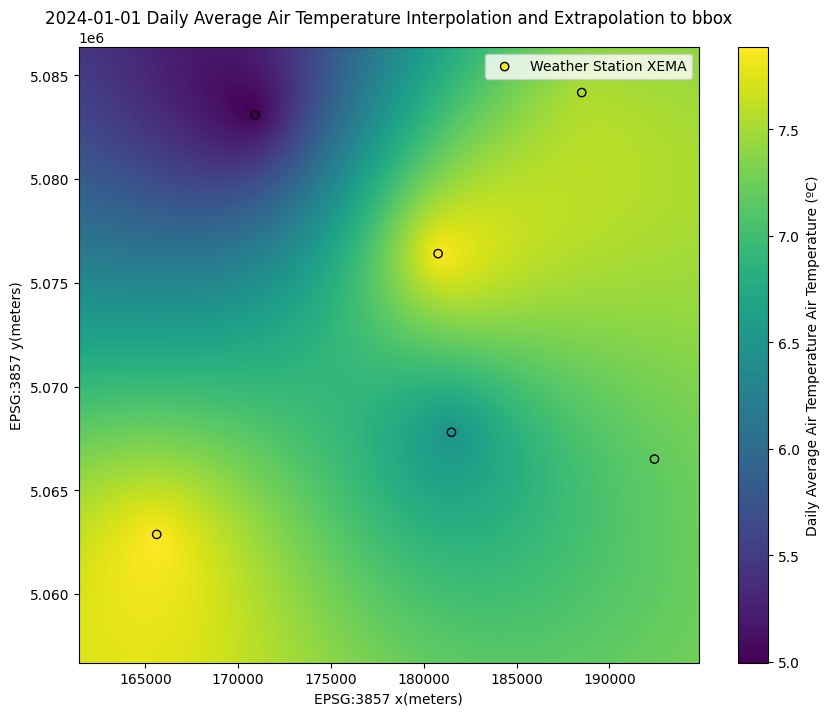

In [49]:
# Graficar el resultado
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, z_dense, levels=1000, cmap="viridis", vmin=vmin, vmax=vmax)  # Mapa de contornos
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values[:,i], cmap="viridis", edgecolor="k", label="Weather Station XEMA", vmin=vmin, vmax=vmax)
plt.colorbar(label="Daily Average Air Temperature Air Temperature (ºC)")
plt.xlabel("EPSG:3857 x(meters)")
plt.ylabel("EPSG:3857 y(meters)")
plt.title("2024-01-01 Daily Average Air Temperature Interpolation and Extrapolation to bbox")
plt.legend()
plt.savefig('temperature_agrixel_plot_4.png')
plt.show()

In [50]:
min_lat, max_lat = 41.4, 41.42
min_lon, max_lon = 1.61, 1.64

resolution = 1

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

xmin, ymin = transformer.transform(min_lat, min_lon)
xmax, ymax = transformer.transform(max_lat, max_lon)

xmin=(xmin//1)*1
xmax=math.ceil(xmax/1)*1
ymin=(ymin//1)*1
ymax=math.ceil(ymax/1)*1

In [51]:
# Extraer las coordenadas x e y y convertirlas en un array 2D
coordinates = np.array([(geom.x, geom.y) for geom in m_estacio_geometry.geometry])

values=pvdf_dades_meteo_temp_daily.values

# Crear una malla densa para la interpolación/extrapolación
x_dense = np.linspace(xmin, xmax, round(xmax-xmin)//1+1)+0.5
y_dense = np.linspace(ymin, ymax, round(ymax-ymin)//1+1)+0.5
x_grid, y_grid = np.meshgrid(x_dense, y_dense)
dense_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

for i in range(1):
    # Crear el interpolador RBF
    rbf_interpolator = RBFInterpolator(coordinates, values[:,i], smoothing=0, kernel="linear")

    # Aplicar el interpolador a los puntos de la malla densa
    z_dense = rbf_interpolator(dense_points).reshape(x_grid.shape)

# Determinar els límits de l'escala de colors
vmin, vmax = z_dense.min(), z_dense.max()

In [52]:
vmin2=values[:,i].min()
vmax2=values[:,i].max()

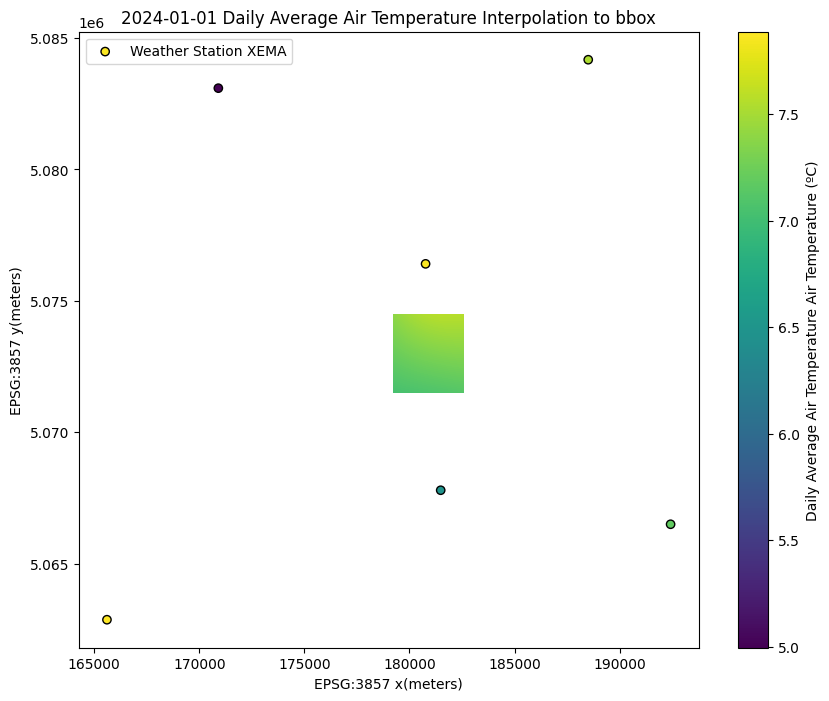

In [53]:
# Graficar el resultado
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, z_dense, levels=1000, cmap="viridis", vmin=vmin2, vmax=vmax2)  # Mapa de contornos
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values[:,i], cmap="viridis", edgecolor="k", label="Weather Station XEMA", vmin=vmin2, vmax=vmax2)
plt.colorbar(label="Daily Average Air Temperature Air Temperature (ºC)")
plt.xlabel("EPSG:3857 x(meters)")
plt.ylabel("EPSG:3857 y(meters)")
plt.title("2024-01-01 Daily Average Air Temperature Interpolation to bbox")
plt.legend()
plt.savefig('temperature_agrixel_plot_3.png')
plt.show()

In [54]:
gdf_agrixels=gpd.read_file("agrixeles-08288_0_0_6_60_1.geojson")

In [55]:
gdf_agrixels

,farm_id,parcel_id,id_rec,sigpac,crop_area_id,agrixel_id,codigo_producto,nombre_producto,codigo_variedad,nombre_variedad,campaña,geometry
0,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_0,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180776 5073427.06, 180776 5073428.06..."
1,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_1,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180776 5073428.06, 180776 5073429.06..."
2,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_2,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180776 5073429.06, 180776 5073430.06..."
3,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_3,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180776 5073430.06, 180776 5073431.06..."
4,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_4,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180776 5073431.06, 180776 5073432.06..."
...,...,...,...,...,...,...,...,...,...,...,...,...
18958,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_18958,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180972 5073548.06, 180972 5073549.06..."
18959,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_18959,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180972 5073549.06, 180972 5073550.06..."
18960,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_18960,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180972 5073550.06, 180972 5073551.06..."
18961,68V4656V5,08288_0_0_6_60,08288:0:0:6:60:1,08288_0_0_6_60_1,08288_0_0_6_60_1_crop_area_1,08288_0_0_6_60_1_Agrixel_18961,107,ALBERCOQUER,23,"COLORADO (AL 1232, 435-15)",2024,"POLYGON ((180973 5073548.06, 180973 5073549.06..."


In [56]:
coordinates = np.array([(geom.x, geom.y) for geom in m_estacio_geometry.geometry])
values=pvdf_dades_meteo_temp_daily.values

In [57]:
centroides = gdf_agrixels.geometry.centroid
array_centroides = np.column_stack((centroides.x, centroides.y))

In [58]:
for i in range(1):
    # Crear el interpolador RBF
    rbf_interpolator = RBFInterpolator(coordinates, values[:,i], smoothing=0, kernel="linear")

    # Aplicar el interpolador a los puntos de la malla densa
    z_dense = rbf_interpolator(array_centroides)

# Determinar els límits de l'escala de colors
vmin, vmax = z_dense.min(), z_dense.max()

In [59]:
gdf_agrixels["interpolated_value"]=z_dense

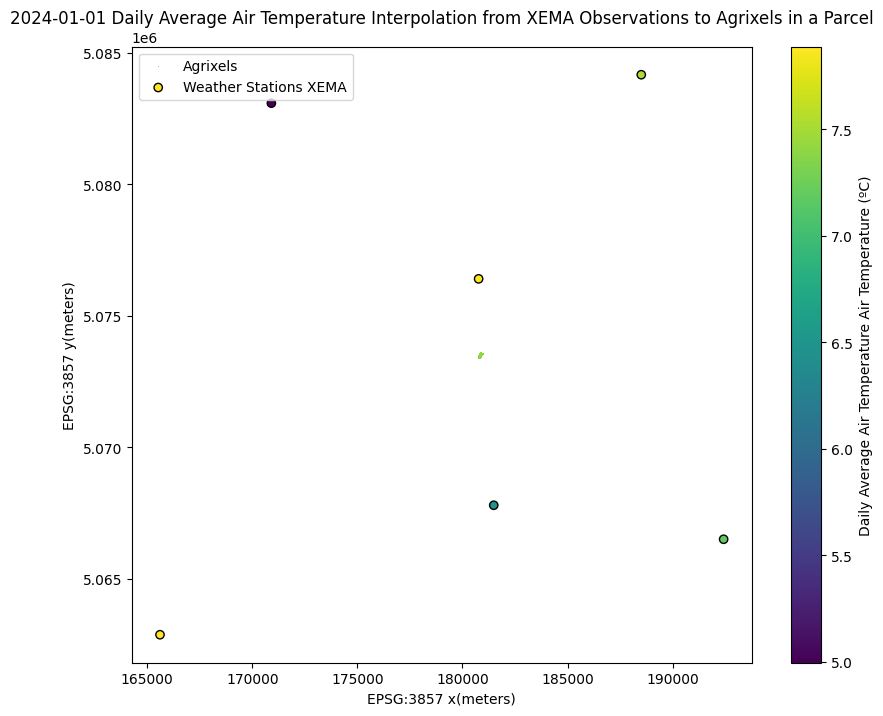

In [60]:
# Graficar el resultado
plt.figure(figsize=(10, 8))
plt.scatter(array_centroides[:,0], array_centroides[:,1], c=z_dense, marker="s", s=1, cmap="viridis", edgecolor='none', label="Agrixels", vmin=vmin2, vmax=vmax2)  # Mapa de contornos
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values[:,i], cmap="viridis", edgecolor="k", label="Weather Stations XEMA", vmin=vmin2, vmax=vmax2)
plt.colorbar(label="Daily Average Air Temperature Air Temperature (ºC)")
plt.xlabel("EPSG:3857 x(meters)")
plt.ylabel("EPSG:3857 y(meters)")
plt.title("2024-01-01 Daily Average Air Temperature Interpolation from XEMA Observations to Agrixels in a Parcel")
plt.legend()
plt.savefig('temperature_agrixel_plot_2.png')
plt.show()

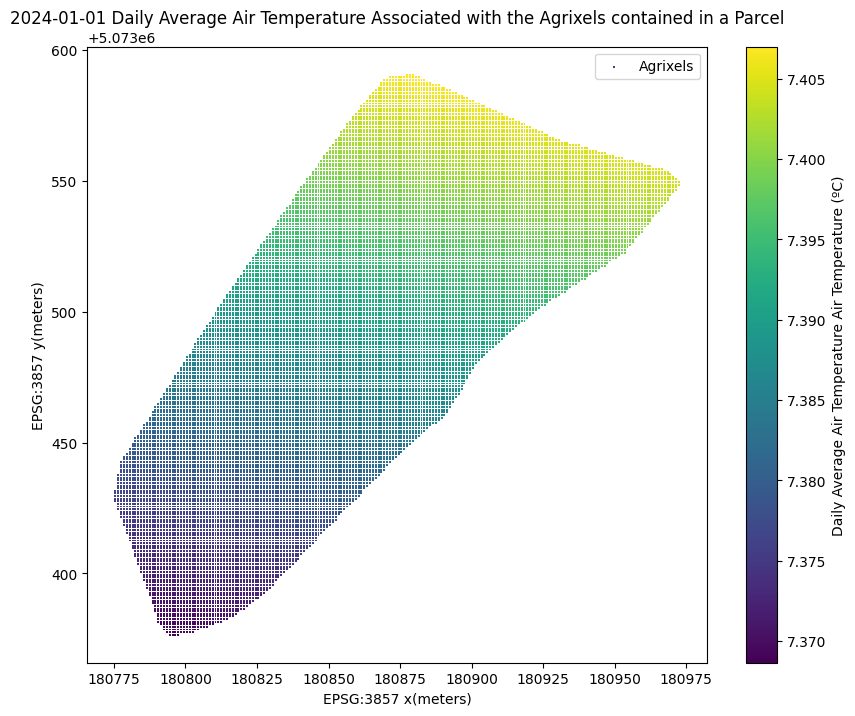

In [61]:
# Graficar el resultado
plt.figure(figsize=(10, 8))
plt.scatter(array_centroides[:,0], array_centroides[:,1], c=z_dense, marker="s", s=2, cmap="viridis", edgecolor='none', label="Agrixels", vmin=vmin, vmax=vmax)  # Mapa de contornos
plt.colorbar(label="Daily Average Air Temperature Air Temperature (ºC)")
plt.xlabel("EPSG:3857 x(meters)")
plt.ylabel("EPSG:3857 y(meters)")
plt.title("2024-01-01 Daily Average Air Temperature Associated with the Agrixels contained in a Parcel")
plt.legend()
plt.savefig('temperature_agrixel_plot.png')
plt.show()

In [62]:
def agrixels_variables_rbf_interpolator(gdf_Features_of_Interest, observedProperty, measures_coordinates, pvdf_measures_location_time, smoothing=0, kernel="linear"):
    # gdf_agrixels: geopandas dataframe with the geometry of the agrixels in field geometry
    # measures_coordinates: array with the measurement points coordinates, 1st dimension sensors, 2nd dimension x,y, values coordinates x,y.
    # measures_values: array with the measurement values, 1st dimension sensors, 2nd dimension time measures t, values measures.
    
    df_interpolated_observations_procedure=pd.DataFrame(columns=['codi_variable','date_id_format'])
    
    df_interpolated_observations=pd.DataFrame(columns=['hasFeatureOfInterest', 'hasSimpleResult', 'codi_variable', 'date_id_format'])
    
    measures_time=pvdf_measures_location_time.columns.values
    
    measures_values=pvdf_measures_location_time.values
    
    centroides = gdf_Features_of_Interest.geometry.centroid
    array_centroides = np.column_stack((centroides.x, centroides.y))
    
    for t in range(10):#measures_values.shape[1]):
        # Crear el interpolador RBF
        rbf_interpolator = RBFInterpolator(measures_coordinates, measures_values[:,t], smoothing=smoothing, kernel=kernel)

        # Aplicar el interpolador a los puntos de la malla densa
        z_dense = rbf_interpolator(array_centroides)
        
        df_interpolated_observations_procedure = pd.concat([df_interpolated_observations_procedure, pd.DataFrame({'codi_variable' : [observedProperty] , 'date_id_format' : [measures_time[t]]})], ignore_index=True)
        
        df_interpolated_observations_new_registers=pd.DataFrame({'hasFeatureOfInterest' : gdf_Features_of_Interest["agrixel_id"], 'hasSimpleResult' : z_dense})
        
        df_interpolated_observations_new_registers['codi_variable']=observedProperty
        
        df_interpolated_observations_new_registers['date_id_format']=measures_time[t]
        
        df_interpolated_observations = pd.concat([df_interpolated_observations, df_interpolated_observations_new_registers], ignore_index=True)

        
    return df_interpolated_observations_procedure, df_interpolated_observations

In [63]:
df_interpolated_observations_procedure, df_interpolated_observations=agrixels_variables_rbf_interpolator(gdf_agrixels, "32", coordinates, pvdf_dades_meteo_temp_daily)

/tmp/ipykernel_447009/2622379353.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_interpolated_observations = pd.concat([df_interpolated_observations, df_interpolated_observations_new_registers], ignore_index=True)


In [64]:
# DataFrame → CSV
df_interpolated_observations.to_csv("df_interpolated_observations.csv", index=False)
df_interpolated_observations_procedure.to_csv("df_interpolated_observations_procedure.csv", index=False)